# Logisitic Regression and Support Vector Machines Minilab

You are to perform predictive analysis (classification) upon a data set: model the dataset using methods we have discussed in class: logistic regression and support vector machines, and making conclusions from the analysis. Follow the CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined below). This report is worth 10% of the final grade. You may complete this assignment in teams of as many as three people.  




By Martin Garcia, Joanna Duran, Daniel Byrne

## Packages

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random

from sklearn.linear_model import SGDClassifier
from sklearn import svm

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Business Understanding

Our objective is to create a logistic regression model and a support vector machine model for the classification of each image. We will determine which is a better model based on prediction accuracy, training time, and efficiency.The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6,000 images per class. 

Our objective is to create a logistic regression model and a support vector machine model for the classification of each image in our test set. We will determine which model is best suited for this standard classification task based on a comparison on their prediction accuracy, training times, and computational efficiency.

## Data Meaning Type

### The CIFAR-10 dataset

We are using the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset which consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The dataset includes are 50000(80%) training images and 10000(20%) test images broken in to 5 pre-randomized training batches and 1 test batch.

Each training batch contains 10,000 observations with a row vector of length 3072 representative of color image of 32x32 pixels. The first 1024 columns consist of red values, followed by green, and blue. The data also incorporates labels ranging from 0 to 9 and are listed below.

* airplane : 0
* automobile : 1
* bird : 2
* cat : 3
* deer : 4
* dog : 5
* frog : 6
* horse : 7
* ship : 8
* truck : 9

The test batch contains 1000 randomly-selected images from each class. The 5 training batches are randomized and contain a variable number of images from each class. 

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

## Simple Statistics

In [2]:
#load the data, reshape to 32x32 matrix per color, transpose matrices
def load_cfar10_batch(path, batch_id = None, reshape = True):
    """
    Argument:
    path -- path the datasets
    batch_id -- id of the batch (1 to 5) to load
    
    Returns:
    parameters -- python dictionary containing:
                    X -- features
                    Y -- labels
    """
    if batch_id is not None:
        filepath = path + 'data_batch_' + str(batch_id)
    else:
        filepath = path
        
    with open(filepath, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
    
    if reshape:    
        X = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        Y = np.array(batch['labels'])
    else:
        X = batch['data']
        Y = np.array(batch['labels'])
        
    return X, Y


Stats of batch #4:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 1003
Label Counts of [1](AUTOMOBILE) : 963
Label Counts of [2](BIRD) : 1041
Label Counts of [3](CAT) : 976
Label Counts of [4](DEER) : 1004
Label Counts of [5](DOG) : 1021
Label Counts of [6](FROG) : 1004
Label Counts of [7](HORSE) : 981
Label Counts of [8](SHIP) : 1024
Label Counts of [9](TRUCK) : 983

Example of Image 1992:
Image - Min Value: 1 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


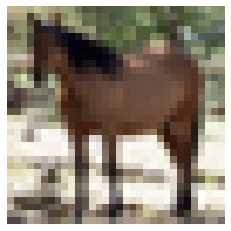

In [3]:
#load labels for our label
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#display images
def display_stats(data, batch_id, sample_id):
    features, labels = load_cfar10_batch(data, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

batch_id = random.randint(1,5)
sample_id = random.randint(1,10000)
display_stats( "data/", batch_id, sample_id)

## Models

In this section we will create a logistic regression model and a support vector machine model for the classification task involved with your dataset.  We will assess how well each model performs (use 80/20 training/testing split)and adjust parameters of the models to make them more accurate. 

### Logistic Regression Model

In [12]:
# Build Logistic Regression Model with Stochastic Gradient Descent 
X,Y = load_cfar10_batch("data/",1,False)

for n in range(2,6):
    x,y = load_cfar10_batch("data/",n,False)
    X = np.concatenate((X,x),axis=0)
    Y = np.concatenate((Y,y),axis=0)

test_X,test_Y = load_cfar10_batch("data/test_batch",None,False)
#labelnames = unpickle("data/batches.meta")

sgdlr = SGDClassifier(alpha=0.001, max_iter=10000, tol=1e-3, verbose = 1,n_jobs=4,loss="log")

print("Data shape: ",X.shape)
print("Labels shape: ",Y.shape)

print("Test Data shape: ",test_X.shape)
print("Test Labels shape: ",test_Y.shape)



Data shape:  (50000, 3072)
Labels shape:  (50000,)
Test Data shape:  (10000, 3072)
Test Labels shape:  (10000,)


In [5]:
sgdlr.fit(X,Y)
score = sgdlr.score(test_X,test_Y)
print(score)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1
-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 2389.76, NNZs: 3072, Bias: -65.104663, T: 50000, Avg. loss: 612042.973957
Total training time: 0.30 seconds.
-- Epoch 2
Norm: 2924.57, NNZs: 3072, Bias: -5.492769, T: 50000, Avg. loss: 454694.329803
Total training time: 0.31 seconds.
-- Epoch 2
Norm: 2023.36, NNZs: 3072, Bias: -13.020730, T: 50000, Avg. loss: 466480.013285
Total training time: 0.31 seconds.
-- Epoch 2
Norm: 2224.27, NNZs: 3072, Bias: -1.726885, T: 50000, Avg. loss: 490321.529476
Total training time: 0.33 seconds.
-- Epoch 2
Norm: 1749.24, NNZs: 3072, Bias: -6.578961, T: 100000, Avg. loss: 51442.408820
Total training time: 0.64 seconds.
-- Epoch 3
Norm: 1555.32, NNZs: 3072, Bias: -72.097725, T: 100000, Avg. loss: 71658.786210
Total training time: 0.65 seconds.
-- Epoch 3
Norm: 1484.53, NNZs: 3072, Bias: -2.480952, T: 100000, Avg. loss: 62342.568696
Total training time: 0.67 seconds.
-- Epoch 3
Norm: 1297.92, NNZs: 3072, Bias: -14.008046, T: 100000, Avg. loss: 61270.76275

-- Epoch 18
Norm: 402.58, NNZs: 3072, Bias: -17.170022, T: 850000, Avg. loss: 5299.650197
Total training time: 6.51 seconds.
-- Epoch 18
Norm: 462.06, NNZs: 3072, Bias: -9.840828, T: 900000, Avg. loss: 4096.775869
Total training time: 6.66 seconds.
-- Epoch 19
Norm: 459.87, NNZs: 3072, Bias: -95.381828, T: 900000, Avg. loss: 5850.629869
Total training time: 6.78 seconds.
-- Epoch 19
Norm: 417.50, NNZs: 3072, Bias: -5.504681, T: 900000, Avg. loss: 5044.117963
Total training time: 6.87 seconds.
-- Epoch 19
Norm: 390.94, NNZs: 3072, Bias: -17.266483, T: 900000, Avg. loss: 5073.860566
Total training time: 6.87 seconds.
-- Epoch 19
Norm: 447.39, NNZs: 3072, Bias: -9.892700, T: 950000, Avg. loss: 3871.877569
Total training time: 7.02 seconds.
-- Epoch 20
Norm: 447.80, NNZs: 3072, Bias: -95.960692, T: 950000, Avg. loss: 5500.753974
Total training time: 7.15 seconds.
-- Epoch 20
Norm: 406.05, NNZs: 3072, Bias: -5.595552, T: 950000, Avg. loss: 4784.126030
Total training time: 7.24 seconds.
-- E

Norm: 334.50, NNZs: 3072, Bias: -101.963159, T: 1700000, Avg. loss: 3039.403366
Total training time: 12.80 seconds.
-- Epoch 35
Norm: 302.57, NNZs: 3072, Bias: -6.439679, T: 1700000, Avg. loss: 2626.642795
Total training time: 13.00 seconds.
-- Epoch 35
Norm: 328.46, NNZs: 3072, Bias: -10.698530, T: 1750000, Avg. loss: 2074.904950
Total training time: 13.01 seconds.
-- Epoch 36
Norm: 283.36, NNZs: 3072, Bias: -18.157853, T: 1700000, Avg. loss: 2610.717643
Total training time: 13.07 seconds.
-- Epoch 35
Norm: 329.51, NNZs: 3072, Bias: -102.265002, T: 1750000, Avg. loss: 2929.870756
Total training time: 13.23 seconds.
-- Epoch 36
Norm: 323.97, NNZs: 3072, Bias: -10.751473, T: 1800000, Avg. loss: 1995.823668
Total training time: 13.43 seconds.
-- Epoch 37
Norm: 297.90, NNZs: 3072, Bias: -6.481574, T: 1750000, Avg. loss: 2551.703873
Total training time: 13.44 seconds.
-- Epoch 36
Norm: 279.48, NNZs: 3072, Bias: -18.220031, T: 1750000, Avg. loss: 2531.394485
Total training time: 13.51 secon

Norm: 246.69, NNZs: 3072, Bias: -6.978821, T: 2500000, Avg. loss: 1797.150990
Total training time: 20.49 seconds.
-- Epoch 51
Norm: 272.95, NNZs: 3072, Bias: -106.153151, T: 2550000, Avg. loss: 1975.285898
Total training time: 20.59 seconds.
-- Epoch 52
Norm: 235.15, NNZs: 3072, Bias: -18.710253, T: 2500000, Avg. loss: 1750.506203
Total training time: 20.59 seconds.
-- Epoch 51
Norm: 269.62, NNZs: 3072, Bias: -11.310879, T: 2600000, Avg. loss: 1377.236427
Total training time: 20.69 seconds.
-- Epoch 53
Norm: 244.17, NNZs: 3072, Bias: -7.005597, T: 2550000, Avg. loss: 1733.988572
Total training time: 20.84 seconds.
-- Epoch 52
Norm: 270.19, NNZs: 3072, Bias: -106.359282, T: 2600000, Avg. loss: 1978.221617
Total training time: 20.94 seconds.
-- Epoch 53
Norm: 232.45, NNZs: 3072, Bias: -18.741018, T: 2550000, Avg. loss: 1722.566122
Total training time: 20.95 seconds.
-- Epoch 52
Norm: 266.78, NNZs: 3072, Bias: -11.336774, T: 2650000, Avg. loss: 1333.142265
Total training time: 21.02 secon

Norm: 233.09, NNZs: 3072, Bias: -11.770011, T: 3450000, Avg. loss: 1020.792235
Total training time: 26.60 seconds.
-- Epoch 70
Norm: 211.83, NNZs: 3072, Bias: -7.446734, T: 3350000, Avg. loss: 1329.786992
Total training time: 26.64 seconds.
-- Epoch 68
Norm: 236.49, NNZs: 3072, Bias: -109.128714, T: 3400000, Avg. loss: 1486.392495
Total training time: 26.64 seconds.
-- Epoch 69
Norm: 203.19, NNZs: 3072, Bias: -19.128592, T: 3350000, Avg. loss: 1306.246003
Total training time: 26.70 seconds.
-- Epoch 68
Norm: 231.55, NNZs: 3072, Bias: -11.793236, T: 3500000, Avg. loss: 1015.894685
Total training time: 26.96 seconds.
-- Epoch 71
Norm: 234.78, NNZs: 3072, Bias: -109.272574, T: 3450000, Avg. loss: 1463.976332
Total training time: 27.00 seconds.
-- Epoch 70
Norm: 210.22, NNZs: 3072, Bias: -7.477738, T: 3400000, Avg. loss: 1305.816944
Total training time: 27.01 seconds.
-- Epoch 69
Norm: 201.82, NNZs: 3072, Bias: -19.150129, T: 3400000, Avg. loss: 1285.843537
Total training time: 27.06 secon

Norm: 211.35, NNZs: 3072, Bias: -111.300418, T: 4200000, Avg. loss: 1215.850549
Total training time: 32.36 seconds.
-- Epoch 85
Norm: 190.88, NNZs: 3072, Bias: -7.805408, T: 4150000, Avg. loss: 1062.035012
Total training time: 32.49 seconds.
-- Epoch 84
Norm: 183.71, NNZs: 3072, Bias: -19.478922, T: 4150000, Avg. loss: 1047.270627
Total training time: 32.55 seconds.
-- Epoch 84
Norm: 208.03, NNZs: 3072, Bias: -12.116000, T: 4300000, Avg. loss: 814.731448
Total training time: 32.62 seconds.
-- Epoch 87
Norm: 210.20, NNZs: 3072, Bias: -111.418201, T: 4250000, Avg. loss: 1179.316271
Total training time: 32.73 seconds.
-- Epoch 86
Norm: 189.60, NNZs: 3072, Bias: -7.825987, T: 4200000, Avg. loss: 1037.561701
Total training time: 32.84 seconds.
-- Epoch 85
Norm: 182.94, NNZs: 3072, Bias: -19.489547, T: 4200000, Avg. loss: 1042.904889
Total training time: 32.90 seconds.
-- Epoch 85
Norm: 207.07, NNZs: 3072, Bias: -12.130731, T: 4350000, Avg. loss: 802.967471
Total training time: 32.95 seconds

Norm: 191.94, NNZs: 3072, Bias: -12.397696, T: 5100000, Avg. loss: 680.207115
Total training time: 38.22 seconds.
-- Epoch 103
Norm: 173.63, NNZs: 3072, Bias: -8.088919, T: 4950000, Avg. loss: 889.100568
Total training time: 38.29 seconds.
-- Epoch 100
Norm: 168.64, NNZs: 3072, Bias: -19.754257, T: 4950000, Avg. loss: 890.597537
Total training time: 38.38 seconds.
-- Epoch 100
Norm: 192.51, NNZs: 3072, Bias: -113.185852, T: 5050000, Avg. loss: 1014.468288
Total training time: 38.45 seconds.
-- Epoch 102
Norm: 190.57, NNZs: 3072, Bias: -12.416335, T: 5150000, Avg. loss: 682.252973
Total training time: 38.58 seconds.
-- Epoch 104
Norm: 172.47, NNZs: 3072, Bias: -8.099910, T: 5000000, Avg. loss: 879.658730
Total training time: 38.66 seconds.
-- Epoch 101
Norm: 168.07, NNZs: 3072, Bias: -19.769680, T: 5000000, Avg. loss: 865.134323
Total training time: 38.75 seconds.
-- Epoch 101
Norm: 191.72, NNZs: 3072, Bias: -113.288840, T: 5100000, Avg. loss: 980.970505
Total training time: 38.81 secon

Norm: 160.60, NNZs: 3072, Bias: -8.313870, T: 5750000, Avg. loss: 760.638089
Total training time: 44.26 seconds.
-- Epoch 116
Norm: 156.29, NNZs: 3072, Bias: -19.965863, T: 5750000, Avg. loss: 758.835055
Total training time: 44.30 seconds.
-- Epoch 116
Norm: 178.48, NNZs: 3072, Bias: -114.708550, T: 5850000, Avg. loss: 860.867385
Total training time: 44.31 seconds.
-- Epoch 118
Norm: 177.20, NNZs: 3072, Bias: -12.650712, T: 5950000, Avg. loss: 588.807171
Total training time: 44.36 seconds.
-- Epoch 120
Norm: 159.89, NNZs: 3072, Bias: -8.328043, T: 5800000, Avg. loss: 750.177372
Total training time: 44.67 seconds.
-- Epoch 117
Norm: 155.70, NNZs: 3072, Bias: -19.979610, T: 5800000, Avg. loss: 751.493529
Total training time: 44.69 seconds.
-- Epoch 117
Norm: 177.89, NNZs: 3072, Bias: -114.798652, T: 5900000, Avg. loss: 849.634237
Total training time: 44.70 seconds.
-- Epoch 119
Norm: 176.40, NNZs: 3072, Bias: -12.668355, T: 6000000, Avg. loss: 578.787056
Total training time: 44.74 second

Norm: 165.72, NNZs: 3072, Bias: -12.883608, T: 6800000, Avg. loss: 515.889705
Total training time: 50.43 seconds.
-- Epoch 137
Norm: 166.84, NNZs: 3072, Bias: -116.098293, T: 6700000, Avg. loss: 747.872136
Total training time: 50.50 seconds.
-- Epoch 135
Norm: 146.17, NNZs: 3072, Bias: -20.184295, T: 6600000, Avg. loss: 661.977029
Total training time: 50.63 seconds.
-- Epoch 133
Norm: 149.87, NNZs: 3072, Bias: -8.538412, T: 6600000, Avg. loss: 661.071193
Total training time: 50.65 seconds.
-- Epoch 133
Norm: 165.02, NNZs: 3072, Bias: -12.896153, T: 6850000, Avg. loss: 510.627211
Total training time: 50.79 seconds.
-- Epoch 138
Norm: 166.21, NNZs: 3072, Bias: -116.175006, T: 6750000, Avg. loss: 743.716970
Total training time: 50.87 seconds.
-- Epoch 136
Norm: 145.61, NNZs: 3072, Bias: -20.197018, T: 6650000, Avg. loss: 650.505536
Total training time: 51.00 seconds.
-- Epoch 134
Norm: 149.10, NNZs: 3072, Bias: -8.549429, T: 6650000, Avg. loss: 657.718159
Total training time: 51.03 second

Norm: 155.86, NNZs: 3072, Bias: -13.080065, T: 7650000, Avg. loss: 456.894625
Total training time: 57.40 seconds.
-- Epoch 154
Norm: 137.69, NNZs: 3072, Bias: -20.382129, T: 7400000, Avg. loss: 588.943795
Total training time: 57.50 seconds.
-- Epoch 149
Norm: 141.05, NNZs: 3072, Bias: -8.742659, T: 7400000, Avg. loss: 590.485176
Total training time: 57.55 seconds.
-- Epoch 149
Norm: 156.99, NNZs: 3072, Bias: -117.324046, T: 7550000, Avg. loss: 668.246876
Total training time: 57.61 seconds.
-- Epoch 152
Norm: 155.42, NNZs: 3072, Bias: -13.089202, T: 7700000, Avg. loss: 452.805807
Total training time: 57.76 seconds.
-- Epoch 155
Norm: 137.32, NNZs: 3072, Bias: -20.392258, T: 7450000, Avg. loss: 583.793990
Total training time: 57.87 seconds.
-- Epoch 150
Norm: 140.47, NNZs: 3072, Bias: -8.753973, T: 7450000, Avg. loss: 582.180458
Total training time: 57.92 seconds.
-- Epoch 150
Norm: 156.59, NNZs: 3072, Bias: -117.388365, T: 7600000, Avg. loss: 646.898553
Total training time: 57.97 second

Norm: 149.16, NNZs: 3072, Bias: -118.350940, T: 8350000, Avg. loss: 599.705053
Total training time: 63.38 seconds.
-- Epoch 168
Norm: 130.53, NNZs: 3072, Bias: -20.545005, T: 8200000, Avg. loss: 530.913711
Total training time: 63.40 seconds.
-- Epoch 165
Norm: 147.87, NNZs: 3072, Bias: -13.241704, T: 8500000, Avg. loss: 407.223718
Total training time: 63.44 seconds.
-- Epoch 171
Norm: 133.99, NNZs: 3072, Bias: -8.898289, T: 8200000, Avg. loss: 537.448909
Total training time: 63.50 seconds.
-- Epoch 165
Norm: 148.69, NNZs: 3072, Bias: -118.412675, T: 8400000, Avg. loss: 587.913797
Total training time: 63.76 seconds.
-- Epoch 169
Norm: 130.04, NNZs: 3072, Bias: -20.555265, T: 8250000, Avg. loss: 522.538745
Total training time: 63.78 seconds.
-- Epoch 166
Norm: 147.35, NNZs: 3072, Bias: -13.253431, T: 8550000, Avg. loss: 401.271103
Total training time: 63.81 seconds.
-- Epoch 172
Norm: 133.59, NNZs: 3072, Bias: -8.907467, T: 8250000, Avg. loss: 519.972669
Total training time: 63.88 second

Norm: 142.43, NNZs: 3072, Bias: -119.283171, T: 9150000, Avg. loss: 542.778529
Total training time: 69.55 seconds.
-- Epoch 184
Norm: 124.41, NNZs: 3072, Bias: -20.696906, T: 9000000, Avg. loss: 482.632340
Total training time: 69.74 seconds.
-- Epoch 181
Norm: 127.97, NNZs: 3072, Bias: -9.043876, T: 9000000, Avg. loss: 481.794826
Total training time: 69.84 seconds.
-- Epoch 181
Norm: 141.12, NNZs: 3072, Bias: -13.404838, T: 9350000, Avg. loss: 373.242776
Total training time: 69.91 seconds.
-- Epoch 188
Norm: 142.07, NNZs: 3072, Bias: -119.336883, T: 9200000, Avg. loss: 535.671242
Total training time: 69.95 seconds.
-- Epoch 185
Norm: 124.14, NNZs: 3072, Bias: -20.706259, T: 9050000, Avg. loss: 469.649915
Total training time: 70.12 seconds.
-- Epoch 182
Norm: 127.73, NNZs: 3072, Bias: -9.051774, T: 9050000, Avg. loss: 478.735527
Total training time: 70.21 seconds.
-- Epoch 182
Norm: 140.77, NNZs: 3072, Bias: -13.412733, T: 9400000, Avg. loss: 367.961476
Total training time: 70.26 second

Norm: 135.35, NNZs: 3072, Bias: -13.541025, T: 10150000, Avg. loss: 339.041297
Total training time: 76.55 seconds.
-- Epoch 204
Norm: 119.65, NNZs: 3072, Bias: -20.834463, T: 9800000, Avg. loss: 445.639184
Total training time: 76.68 seconds.
-- Epoch 197
Norm: 136.24, NNZs: 3072, Bias: -120.190379, T: 10000000, Avg. loss: 501.865140
Total training time: 76.75 seconds.
-- Epoch 201
Norm: 122.70, NNZs: 3072, Bias: -9.185778, T: 9800000, Avg. loss: 444.071269
Total training time: 76.76 seconds.
-- Epoch 197
Norm: 135.06, NNZs: 3072, Bias: -13.547667, T: 10200000, Avg. loss: 337.140354
Total training time: 76.92 seconds.
-- Epoch 205
Norm: 119.37, NNZs: 3072, Bias: -20.843607, T: 9850000, Avg. loss: 440.366399
Total training time: 77.06 seconds.
-- Epoch 198
Norm: 135.93, NNZs: 3072, Bias: -120.242175, T: 10050000, Avg. loss: 497.030485
Total training time: 77.12 seconds.
-- Epoch 202
Norm: 122.44, NNZs: 3072, Bias: -9.192612, T: 9850000, Avg. loss: 437.250169
Total training time: 77.14 se

Norm: 129.93, NNZs: 3072, Bias: -13.678705, T: 11000000, Avg. loss: 308.743733
Total training time: 82.80 seconds.
-- Epoch 221
Norm: 115.01, NNZs: 3072, Bias: -20.966508, T: 10600000, Avg. loss: 402.413338
Total training time: 82.83 seconds.
-- Epoch 213
Norm: 117.99, NNZs: 3072, Bias: -9.307135, T: 10600000, Avg. loss: 404.764972
Total training time: 82.89 seconds.
-- Epoch 213
Norm: 130.68, NNZs: 3072, Bias: -121.029163, T: 10850000, Avg. loss: 455.510526
Total training time: 83.03 seconds.
-- Epoch 218
Norm: 129.65, NNZs: 3072, Bias: -13.686793, T: 11050000, Avg. loss: 310.840806
Total training time: 83.15 seconds.
-- Epoch 222
Norm: 114.75, NNZs: 3072, Bias: -20.974495, T: 10650000, Avg. loss: 405.201292
Total training time: 83.20 seconds.
-- Epoch 214
Norm: 117.72, NNZs: 3072, Bias: -9.314985, T: 10650000, Avg. loss: 406.427837
Total training time: 83.25 seconds.
-- Epoch 214
Norm: 130.39, NNZs: 3072, Bias: -121.074084, T: 10900000, Avg. loss: 456.313024
Total training time: 83.4

Norm: 110.91, NNZs: 3072, Bias: -21.086533, T: 11400000, Avg. loss: 378.362568
Total training time: 88.97 seconds.
-- Epoch 229
Norm: 113.67, NNZs: 3072, Bias: -9.438211, T: 11400000, Avg. loss: 379.577075
Total training time: 89.02 seconds.
-- Epoch 229
Norm: 126.07, NNZs: 3072, Bias: -121.750641, T: 11650000, Avg. loss: 425.813766
Total training time: 89.02 seconds.
-- Epoch 234
Norm: 125.27, NNZs: 3072, Bias: -13.799219, T: 11850000, Avg. loss: 292.005718
Total training time: 89.05 seconds.
-- Epoch 238
Norm: 110.65, NNZs: 3072, Bias: -21.091541, T: 11450000, Avg. loss: 377.497832
Total training time: 89.36 seconds.
-- Epoch 230
Norm: 113.36, NNZs: 3072, Bias: -9.445076, T: 11450000, Avg. loss: 380.658530
Total training time: 89.41 seconds.
-- Epoch 230
Norm: 125.74, NNZs: 3072, Bias: -121.794023, T: 11700000, Avg. loss: 419.979203
Total training time: 89.41 seconds.
-- Epoch 235
Norm: 125.07, NNZs: 3072, Bias: -13.804916, T: 11900000, Avg. loss: 288.178197
Total training time: 89.4

-- Epoch 250
Norm: 107.07, NNZs: 3072, Bias: -21.197631, T: 12200000, Avg. loss: 351.788771
Total training time: 95.25 seconds.
-- Epoch 245
Norm: 109.82, NNZs: 3072, Bias: -9.539902, T: 12200000, Avg. loss: 356.160954
Total training time: 95.32 seconds.
-- Epoch 245
Norm: 121.08, NNZs: 3072, Bias: -13.914472, T: 12700000, Avg. loss: 271.939558
Total training time: 95.45 seconds.
-- Epoch 255
Norm: 121.61, NNZs: 3072, Bias: -122.468208, T: 12500000, Avg. loss: 394.297746
Total training time: 95.51 seconds.
-- Epoch 251
Norm: 106.84, NNZs: 3072, Bias: -21.203829, T: 12250000, Avg. loss: 355.068569
Total training time: 95.67 seconds.
-- Epoch 246
Norm: 109.53, NNZs: 3072, Bias: -9.548716, T: 12250000, Avg. loss: 354.305268
Total training time: 95.74 seconds.
-- Epoch 246
Norm: 120.88, NNZs: 3072, Bias: -13.920511, T: 12750000, Avg. loss: 269.335131
Total training time: 95.84 seconds.
-- Epoch 256
Norm: 121.35, NNZs: 3072, Bias: -122.509319, T: 12550000, Avg. loss: 389.603544
Total traini

Norm: 425.99, NNZs: 3072, Bias: -9.025512, T: 750000, Avg. loss: 5391.794685
Total training time: 5.78 seconds.
-- Epoch 16
Norm: 117.82, NNZs: 3072, Bias: -123.098208, T: 13300000, Avg. loss: 368.136986
Total training time: 102.06 seconds.
-- Epoch 267
Norm: 103.55, NNZs: 3072, Bias: -21.302031, T: 13000000, Avg. loss: 330.796359
Total training time: 102.07 seconds.
-- Epoch 261
Norm: 106.12, NNZs: 3072, Bias: -9.647271, T: 13000000, Avg. loss: 331.058063
Total training time: 102.11 seconds.
-- Epoch 261
Norm: 414.22, NNZs: 3072, Bias: -9.062350, T: 800000, Avg. loss: 5036.754079
Total training time: 6.27 seconds.
-- Epoch 17
Norm: 117.61, NNZs: 3072, Bias: -123.133310, T: 13350000, Avg. loss: 365.279224
Total training time: 102.59 seconds.
-- Epoch 268
Norm: 103.32, NNZs: 3072, Bias: -21.308914, T: 13050000, Avg. loss: 333.443585
Total training time: 102.62 seconds.
-- Epoch 262
Norm: 105.94, NNZs: 3072, Bias: -9.651526, T: 13050000, Avg. loss: 334.643180
Total training time: 102.65 

Norm: 100.61, NNZs: 3072, Bias: -21.398377, T: 13800000, Avg. loss: 311.674860
Total training time: 108.70 seconds.
-- Epoch 277
Norm: 285.50, NNZs: 3072, Bias: -9.533428, T: 1650000, Avg. loss: 2417.416157
Total training time: 12.50 seconds.
-- Epoch 34
Norm: 103.18, NNZs: 3072, Bias: -9.734423, T: 13800000, Avg. loss: 313.543539
Total training time: 108.74 seconds.
-- Epoch 277
Norm: 114.22, NNZs: 3072, Bias: -123.715505, T: 14150000, Avg. loss: 343.749836
Total training time: 108.88 seconds.
-- Epoch 284
Norm: 282.12, NNZs: 3072, Bias: -9.556200, T: 1700000, Avg. loss: 2317.198934
Total training time: 12.90 seconds.
-- Epoch 35
Norm: 100.42, NNZs: 3072, Bias: -21.402790, T: 13850000, Avg. loss: 309.043542
Total training time: 109.12 seconds.
-- Epoch 278
Norm: 102.95, NNZs: 3072, Bias: -9.740448, T: 13850000, Avg. loss: 312.850314
Total training time: 109.16 seconds.
-- Epoch 278
Norm: 114.03, NNZs: 3072, Bias: -123.751906, T: 14200000, Avg. loss: 349.261789
Total training time: 109

Norm: 233.11, NNZs: 3072, Bias: -9.840764, T: 2500000, Avg. loss: 1557.383535
Total training time: 19.52 seconds.
-- Epoch 51
Norm: 111.11, NNZs: 3072, Bias: -124.265818, T: 14950000, Avg. loss: 329.089512
Total training time: 115.91 seconds.
-- Epoch 300
Norm: 100.23, NNZs: 3072, Bias: -9.822123, T: 14600000, Avg. loss: 294.742049
Total training time: 116.08 seconds.
-- Epoch 293
Norm: 97.71, NNZs: 3072, Bias: -21.484600, T: 14600000, Avg. loss: 293.591909
Total training time: 116.09 seconds.
-- Epoch 293
Norm: 230.39, NNZs: 3072, Bias: -9.857172, T: 2550000, Avg. loss: 1530.248856
Total training time: 19.99 seconds.
-- Epoch 52
Norm: 110.93, NNZs: 3072, Bias: -124.298490, T: 15000000, Avg. loss: 325.750059
Total training time: 116.38 seconds.
-- Epoch 301
Norm: 100.08, NNZs: 3072, Bias: -9.826692, T: 14650000, Avg. loss: 294.327565
Total training time: 116.50 seconds.
-- Epoch 294
Norm: 97.57, NNZs: 3072, Bias: -21.491094, T: 14650000, Avg. loss: 295.088741
Total training time: 116.5

Norm: 197.23, NNZs: 3072, Bias: -10.041557, T: 3400000, Avg. loss: 1146.258176
Total training time: 27.06 seconds.
-- Epoch 69
Norm: 97.50, NNZs: 3072, Bias: -9.904608, T: 15400000, Avg. loss: 279.707691
Total training time: 123.44 seconds.
-- Epoch 309
Norm: 95.34, NNZs: 3072, Bias: -21.572354, T: 15400000, Avg. loss: 280.041174
Total training time: 123.45 seconds.
-- Epoch 309
Norm: 107.84, NNZs: 3072, Bias: -124.826626, T: 15800000, Avg. loss: 307.470297
Total training time: 123.48 seconds.
-- Epoch 317
Norm: 195.67, NNZs: 3072, Bias: -10.048033, T: 3450000, Avg. loss: 1134.748041
Total training time: 27.45 seconds.
-- Epoch 70
Norm: 97.30, NNZs: 3072, Bias: -9.910646, T: 15450000, Avg. loss: 279.722196
Total training time: 123.93 seconds.
-- Epoch 310
Norm: 95.18, NNZs: 3072, Bias: -21.578569, T: 15450000, Avg. loss: 279.239755
Total training time: 123.94 seconds.
-- Epoch 310
Norm: 107.71, NNZs: 3072, Bias: -124.858454, T: 15850000, Avg. loss: 311.559121
Total training time: 123.9

Norm: 105.18, NNZs: 3072, Bias: -125.319472, T: 16600000, Avg. loss: 298.332484
Total training time: 130.27 seconds.
-- Epoch 333
Norm: 174.94, NNZs: 3072, Bias: -10.220305, T: 4300000, Avg. loss: 898.881343
Total training time: 34.26 seconds.
-- Epoch 87
Norm: 92.86, NNZs: 3072, Bias: -21.652908, T: 16200000, Avg. loss: 262.911302
Total training time: 130.57 seconds.
-- Epoch 325
Norm: 95.13, NNZs: 3072, Bias: -9.991151, T: 16200000, Avg. loss: 264.095241
Total training time: 130.57 seconds.
-- Epoch 325
Norm: 105.02, NNZs: 3072, Bias: -125.348266, T: 16650000, Avg. loss: 295.473521
Total training time: 130.79 seconds.
-- Epoch 334
Norm: 173.87, NNZs: 3072, Bias: -10.237127, T: 4350000, Avg. loss: 897.994270
Total training time: 34.71 seconds.
-- Epoch 88
Norm: 92.71, NNZs: 3072, Bias: -21.659279, T: 16250000, Avg. loss: 262.123100
Total training time: 131.04 seconds.
-- Epoch 326
Norm: 94.97, NNZs: 3072, Bias: -9.997147, T: 16250000, Avg. loss: 264.792275
Total training time: 131.04 

Norm: 92.70, NNZs: 3072, Bias: -10.063087, T: 17000000, Avg. loss: 253.014801
Total training time: 137.44 seconds.
-- Epoch 341
Norm: 102.50, NNZs: 3072, Bias: -125.815895, T: 17450000, Avg. loss: 282.981072
Total training time: 137.46 seconds.
-- Epoch 350
Norm: 158.89, NNZs: 3072, Bias: -10.385610, T: 5200000, Avg. loss: 743.759789
Total training time: 41.30 seconds.
-- Epoch 105
Norm: 90.61, NNZs: 3072, Bias: -21.729085, T: 17000000, Avg. loss: 251.380784
Total training time: 137.55 seconds.
-- Epoch 341
Norm: 102.41, NNZs: 3072, Bias: -125.844640, T: 17500000, Avg. loss: 279.080946
Total training time: 138.04 seconds.
-- Epoch 351
Norm: 92.61, NNZs: 3072, Bias: -10.068441, T: 17050000, Avg. loss: 248.290811
Total training time: 138.04 seconds.
-- Epoch 342
Norm: 158.08, NNZs: 3072, Bias: -10.396755, T: 5250000, Avg. loss: 742.345169
Total training time: 41.86 seconds.
-- Epoch 106
Norm: 90.48, NNZs: 3072, Bias: -21.733940, T: 17050000, Avg. loss: 251.037028
Total training time: 138

-- Epoch 356
Norm: 100.20, NNZs: 3072, Bias: -126.263270, T: 18250000, Avg. loss: 265.967278
Total training time: 144.97 seconds.
-- Epoch 366
Norm: 147.12, NNZs: 3072, Bias: -10.514395, T: 6050000, Avg. loss: 645.988402
Total training time: 48.83 seconds.
-- Epoch 122
Norm: 493.29, NNZs: 3072, Bias: -60.973519, T: 550000, Avg. loss: 8165.843935
Total training time: 4.36 seconds.
-- Epoch 12
Norm: 88.39, NNZs: 3072, Bias: -21.802954, T: 17800000, Avg. loss: 238.163329
Total training time: 145.45 seconds.
-- Epoch 357
Norm: 100.07, NNZs: 3072, Bias: -126.288737, T: 18300000, Avg. loss: 267.771625
Total training time: 145.58 seconds.
-- Epoch 367
Norm: 471.95, NNZs: 3072, Bias: -61.533846, T: 600000, Avg. loss: 7396.236857
Total training time: 4.92 seconds.
-- Epoch 13
Norm: 146.41, NNZs: 3072, Bias: -10.520849, T: 6100000, Avg. loss: 635.332922
Total training time: 49.42 seconds.
-- Epoch 123
Norm: 88.30, NNZs: 3072, Bias: -21.808861, T: 17850000, Avg. loss: 240.986199
Total training ti

Norm: 137.98, NNZs: 3072, Bias: -10.627921, T: 6900000, Avg. loss: 555.559632
Total training time: 56.38 seconds.
-- Epoch 139
Norm: 86.62, NNZs: 3072, Bias: -21.876683, T: 18550000, Avg. loss: 233.544025
Total training time: 152.70 seconds.
-- Epoch 372
Norm: 514.66, NNZs: 3072, Bias: 5.165784, T: 650000, Avg. loss: 5439.344928
Total training time: 5.35 seconds.
-- Epoch 14
Norm: 298.58, NNZs: 3072, Bias: -66.727144, T: 1450000, Avg. loss: 2996.851622
Total training time: 12.04 seconds.
-- Epoch 30
Norm: 137.46, NNZs: 3072, Bias: -10.632821, T: 6950000, Avg. loss: 553.783280
Total training time: 56.75 seconds.
-- Epoch 140
Norm: 496.39, NNZs: 3072, Bias: 5.181295, T: 700000, Avg. loss: 4998.716876
Total training time: 5.70 seconds.
-- Epoch 15
Norm: 292.08, NNZs: 3072, Bias: -66.956584, T: 1500000, Avg. loss: 2836.412063
Total training time: 12.40 seconds.
-- Epoch 31
Norm: 86.49, NNZs: 3072, Bias: -21.881564, T: 18600000, Avg. loss: 230.307133
Total training time: 153.12 seconds.
-- 

Norm: 234.33, NNZs: 3072, Bias: -69.499003, T: 2300000, Avg. loss: 1861.033969
Total training time: 18.23 seconds.
-- Epoch 47
Norm: 130.07, NNZs: 3072, Bias: -10.727395, T: 7750000, Avg. loss: 492.182452
Total training time: 62.80 seconds.
-- Epoch 156
Norm: 84.92, NNZs: 3072, Bias: -21.940153, T: 19300000, Avg. loss: 221.270834
Total training time: 159.02 seconds.
-- Epoch 387
Norm: 333.49, NNZs: 3072, Bias: 5.420853, T: 1550000, Avg. loss: 2186.942538
Total training time: 11.72 seconds.
-- Epoch 32
Norm: 231.57, NNZs: 3072, Bias: -69.638498, T: 2350000, Avg. loss: 1817.832156
Total training time: 18.61 seconds.
-- Epoch 48
Norm: 129.48, NNZs: 3072, Bias: -10.734806, T: 7800000, Avg. loss: 492.890223
Total training time: 63.20 seconds.
-- Epoch 157
Norm: 328.29, NNZs: 3072, Bias: 5.414643, T: 1600000, Avg. loss: 2125.446463
Total training time: 12.08 seconds.
-- Epoch 33
Norm: 84.78, NNZs: 3072, Bias: -21.944100, T: 19350000, Avg. loss: 222.179919
Total training time: 159.47 seconds.

Total training time: 18.42 seconds.
-- Epoch 49
Norm: 201.45, NNZs: 3072, Bias: -71.413644, T: 3150000, Avg. loss: 1354.709828
Total training time: 25.14 seconds.
-- Epoch 64
Norm: 83.26, NNZs: 3072, Bias: -22.001012, T: 20050000, Avg. loss: 212.801326
Total training time: 166.05 seconds.
-- Epoch 402
Norm: 264.64, NNZs: 3072, Bias: 5.476366, T: 2450000, Avg. loss: 1358.228106
Total training time: 18.82 seconds.
-- Epoch 50
Norm: 123.29, NNZs: 3072, Bias: -10.804910, T: 8600000, Avg. loss: 445.245431
Total training time: 69.99 seconds.
-- Epoch 173
Norm: 200.30, NNZs: 3072, Bias: -71.507379, T: 3200000, Avg. loss: 1316.231297
Total training time: 25.55 seconds.
-- Epoch 65
Norm: 83.16, NNZs: 3072, Bias: -22.005406, T: 20100000, Avg. loss: 212.537037
Total training time: 166.62 seconds.
-- Epoch 403
Norm: 261.67, NNZs: 3072, Bias: 5.485234, T: 2500000, Avg. loss: 1332.646333
Total training time: 19.32 seconds.
-- Epoch 51
Norm: 122.91, NNZs: 3072, Bias: -10.811306, T: 8650000, Avg. loss

Norm: 178.96, NNZs: 3072, Bias: -72.853654, T: 4000000, Avg. loss: 1054.154371
Total training time: 33.25 seconds.
-- Epoch 81
Norm: 225.62, NNZs: 3072, Bias: 5.529803, T: 3300000, Avg. loss: 990.898472
Total training time: 26.71 seconds.
-- Epoch 67
Norm: 117.97, NNZs: 3072, Bias: -10.874017, T: 9400000, Avg. loss: 413.993234
Total training time: 77.91 seconds.
-- Epoch 189
Norm: 81.70, NNZs: 3072, Bias: -22.058600, T: 20800000, Avg. loss: 203.713268
Total training time: 174.26 seconds.
-- Epoch 417
Norm: 177.94, NNZs: 3072, Bias: -72.926795, T: 4050000, Avg. loss: 1042.539026
Total training time: 33.64 seconds.
-- Epoch 82
Norm: 224.27, NNZs: 3072, Bias: 5.533142, T: 3350000, Avg. loss: 985.741319
Total training time: 27.11 seconds.
-- Epoch 68
Norm: 117.65, NNZs: 3072, Bias: -10.879028, T: 9450000, Avg. loss: 406.188286
Total training time: 78.34 seconds.
-- Epoch 190
Norm: 81.59, NNZs: 3072, Bias: -22.062966, T: 20850000, Avg. loss: 206.208233
Total training time: 174.72 seconds.
-

Norm: 199.07, NNZs: 3072, Bias: 5.548284, T: 4200000, Avg. loss: 781.394820
Total training time: 33.59 seconds.
-- Epoch 85
Norm: 161.45, NNZs: 3072, Bias: -74.062036, T: 4900000, Avg. loss: 861.529653
Total training time: 40.37 seconds.
-- Epoch 99
Norm: 80.19, NNZs: 3072, Bias: -22.116329, T: 21550000, Avg. loss: 199.201387
Total training time: 181.12 seconds.
-- Epoch 432
Norm: 112.95, NNZs: 3072, Bias: -10.948387, T: 10250000, Avg. loss: 375.686257
Total training time: 84.94 seconds.
-- Epoch 206
Norm: 197.81, NNZs: 3072, Bias: 5.548489, T: 4250000, Avg. loss: 763.987111
Total training time: 33.96 seconds.
-- Epoch 86
Norm: 160.80, NNZs: 3072, Bias: -74.124300, T: 4950000, Avg. loss: 834.893495
Total training time: 40.78 seconds.
-- Epoch 100
Norm: 112.65, NNZs: 3072, Bias: -10.951312, T: 10300000, Avg. loss: 372.476764
Total training time: 85.37 seconds.
-- Epoch 207
Norm: 80.10, NNZs: 3072, Bias: -22.119766, T: 21600000, Avg. loss: 197.520931
Total training time: 181.59 seconds.


Norm: 108.85, NNZs: 3072, Bias: -11.008635, T: 11050000, Avg. loss: 348.446712
Total training time: 91.33 seconds.
-- Epoch 222
Norm: 149.07, NNZs: 3072, Bias: -75.014649, T: 5750000, Avg. loss: 725.517066
Total training time: 46.90 seconds.
-- Epoch 116
Norm: 179.38, NNZs: 3072, Bias: 5.565409, T: 5100000, Avg. loss: 636.838489
Total training time: 40.25 seconds.
-- Epoch 103
Norm: 78.79, NNZs: 3072, Bias: -22.173110, T: 22300000, Avg. loss: 192.033410
Total training time: 187.77 seconds.
-- Epoch 447
Norm: 108.57, NNZs: 3072, Bias: -11.010686, T: 11100000, Avg. loss: 346.836459
Total training time: 91.71 seconds.
-- Epoch 223
Norm: 148.43, NNZs: 3072, Bias: -75.064549, T: 5800000, Avg. loss: 724.335348
Total training time: 47.26 seconds.
-- Epoch 117
Norm: 178.60, NNZs: 3072, Bias: 5.561969, T: 5150000, Avg. loss: 634.741294
Total training time: 40.61 seconds.
-- Epoch 104
Norm: 78.71, NNZs: 3072, Bias: -22.176955, T: 22350000, Avg. loss: 189.680308
Total training time: 188.19 second

-- Epoch 120
Norm: 77.50, NNZs: 3072, Bias: -22.224945, T: 23000000, Avg. loss: 185.763339
Total training time: 193.98 seconds.
-- Epoch 461
Norm: 139.49, NNZs: 3072, Bias: -75.849973, T: 6600000, Avg. loss: 634.908197
Total training time: 53.40 seconds.
-- Epoch 133
Norm: 1041.65, NNZs: 3072, Bias: -15.343756, T: 250000, Avg. loss: 17435.512606
Total training time: 1.78 seconds.
-- Epoch 6
Norm: 164.71, NNZs: 3072, Bias: 5.585249, T: 6000000, Avg. loss: 537.963474
Total training time: 46.96 seconds.
-- Epoch 121
Norm: 77.41, NNZs: 3072, Bias: -22.228640, T: 23050000, Avg. loss: 186.081346
Total training time: 194.44 seconds.
-- Epoch 462
Norm: 138.92, NNZs: 3072, Bias: -75.893984, T: 6650000, Avg. loss: 635.587559
Total training time: 53.79 seconds.
-- Epoch 134
Norm: 929.69, NNZs: 3072, Bias: -15.893635, T: 300000, Avg. loss: 14369.321128
Total training time: 2.17 seconds.
-- Epoch 7
Norm: 163.98, NNZs: 3072, Bias: 5.585983, T: 6050000, Avg. loss: 537.515183
Total training time: 47.4

Norm: 419.76, NNZs: 3072, Bias: -19.917078, T: 1150000, Avg. loss: 3417.617517
Total training time: 8.29 seconds.
-- Epoch 24
Norm: 131.67, NNZs: 3072, Bias: -76.569247, T: 7450000, Avg. loss: 562.274769
Total training time: 59.98 seconds.
-- Epoch 150
Norm: 76.26, NNZs: 3072, Bias: -22.274754, T: 23750000, Avg. loss: 181.092346
Total training time: 200.68 seconds.
-- Epoch 476
Norm: 153.42, NNZs: 3072, Bias: 5.583674, T: 6850000, Avg. loss: 479.111935
Total training time: 53.35 seconds.
-- Epoch 138
Norm: 409.35, NNZs: 3072, Bias: -20.054599, T: 1200000, Avg. loss: 3259.519659
Total training time: 8.63 seconds.
-- Epoch 25
Norm: 131.03, NNZs: 3072, Bias: -76.611445, T: 7500000, Avg. loss: 560.510258
Total training time: 60.35 seconds.
-- Epoch 151
Norm: 152.78, NNZs: 3072, Bias: 5.582877, T: 6900000, Avg. loss: 472.679559
Total training time: 53.71 seconds.
-- Epoch 139
Norm: 76.18, NNZs: 3072, Bias: -22.279530, T: 23800000, Avg. loss: 178.657137
Total training time: 201.12 seconds.
-

Norm: 75.09, NNZs: 3072, Bias: -22.323622, T: 24450000, Avg. loss: 176.727831
Total training time: 207.08 seconds.
-- Epoch 490
Norm: 144.14, NNZs: 3072, Bias: 5.585312, T: 7700000, Avg. loss: 421.740981
Total training time: 59.79 seconds.
-- Epoch 155
Norm: 302.30, NNZs: 3072, Bias: -21.755523, T: 2050000, Avg. loss: 1896.961675
Total training time: 14.86 seconds.
-- Epoch 42
Norm: 124.65, NNZs: 3072, Bias: -77.207713, T: 8300000, Avg. loss: 503.172410
Total training time: 66.65 seconds.
-- Epoch 167
Norm: 75.00, NNZs: 3072, Bias: -22.326821, T: 24500000, Avg. loss: 174.940385
Total training time: 207.54 seconds.
-- Epoch 491
Norm: 143.73, NNZs: 3072, Bias: 5.586143, T: 7750000, Avg. loss: 414.940503
Total training time: 60.18 seconds.
-- Epoch 156
Norm: 297.97, NNZs: 3072, Bias: -21.832103, T: 2100000, Avg. loss: 1824.207921
Total training time: 15.23 seconds.
-- Epoch 43
Norm: 124.27, NNZs: 3072, Bias: -77.240016, T: 8350000, Avg. loss: 499.878862
Total training time: 67.05 seconds.

Norm: 119.32, NNZs: 3072, Bias: -77.747910, T: 9100000, Avg. loss: 459.211550
Total training time: 73.22 seconds.
-- Epoch 183
Norm: 136.36, NNZs: 3072, Bias: 5.589680, T: 8550000, Avg. loss: 376.033021
Total training time: 66.56 seconds.
-- Epoch 172
Norm: 245.38, NNZs: 3072, Bias: -22.835525, T: 2950000, Avg. loss: 1297.001654
Total training time: 21.72 seconds.
-- Epoch 60
Norm: 74.01, NNZs: 3072, Bias: -22.369764, T: 25200000, Avg. loss: 170.665725
Total training time: 214.16 seconds.
-- Epoch 505
Norm: 119.03, NNZs: 3072, Bias: -77.780387, T: 9150000, Avg. loss: 452.413825
Total training time: 73.64 seconds.
-- Epoch 184
Norm: 136.01, NNZs: 3072, Bias: 5.591543, T: 8600000, Avg. loss: 378.093653
Total training time: 66.97 seconds.
-- Epoch 173
Norm: 242.67, NNZs: 3072, Bias: -22.886076, T: 3000000, Avg. loss: 1280.082873
Total training time: 22.10 seconds.
-- Epoch 61
Norm: 73.92, NNZs: 3072, Bias: -22.373724, T: 25250000, Avg. loss: 169.573312
Total training time: 214.73 seconds.

Norm: 73.00, NNZs: 3072, Bias: -22.415837, T: 25900000, Avg. loss: 165.210827
Total training time: 220.89 seconds.
-- Epoch 519
Norm: 211.05, NNZs: 3072, Bias: -23.666434, T: 3850000, Avg. loss: 986.778374
Total training time: 28.59 seconds.
-- Epoch 78
Norm: 114.10, NNZs: 3072, Bias: -78.267490, T: 9950000, Avg. loss: 417.135775
Total training time: 80.27 seconds.
-- Epoch 200
Norm: 129.57, NNZs: 3072, Bias: 5.595100, T: 9450000, Avg. loss: 339.461956
Total training time: 73.74 seconds.
-- Epoch 190
Norm: 209.41, NNZs: 3072, Bias: -23.708654, T: 3900000, Avg. loss: 966.865041
Total training time: 28.95 seconds.
-- Epoch 79
Norm: 72.90, NNZs: 3072, Bias: -22.418526, T: 25950000, Avg. loss: 164.998786
Total training time: 221.34 seconds.
Convergence after 519 epochs took 221.34 seconds
-- Epoch 1
Norm: 113.81, NNZs: 3072, Bias: -78.294683, T: 10000000, Avg. loss: 416.706374
Total training time: 80.69 seconds.
-- Epoch 201
Norm: 129.15, NNZs: 3072, Bias: 5.596750, T: 9500000, Avg. loss: 

Norm: 486.14, NNZs: 3072, Bias: -76.259912, T: 800000, Avg. loss: 5708.382323
Total training time: 5.84 seconds.
-- Epoch 17
Norm: 189.16, NNZs: 3072, Bias: -24.298787, T: 4700000, Avg. loss: 816.893880
Total training time: 34.95 seconds.
-- Epoch 95
Norm: 124.36, NNZs: 3072, Bias: 5.604355, T: 10250000, Avg. loss: 315.255699
Total training time: 79.95 seconds.
-- Epoch 206
Norm: 110.07, NNZs: 3072, Bias: -78.720415, T: 10750000, Avg. loss: 392.098012
Total training time: 86.70 seconds.
-- Epoch 216
Norm: 471.20, NNZs: 3072, Bias: -76.801234, T: 850000, Avg. loss: 5359.691069
Total training time: 6.20 seconds.
-- Epoch 18
Norm: 187.93, NNZs: 3072, Bias: -24.330891, T: 4750000, Avg. loss: 794.732358
Total training time: 35.33 seconds.
-- Epoch 96
Norm: 123.97, NNZs: 3072, Bias: 5.605609, T: 10300000, Avg. loss: 313.479643
Total training time: 80.35 seconds.
-- Epoch 207
Norm: 109.79, NNZs: 3072, Bias: -78.747589, T: 10800000, Avg. loss: 381.418935
Total training time: 87.11 seconds.
-- 

Norm: 106.52, NNZs: 3072, Bias: -79.116738, T: 11500000, Avg. loss: 360.359149
Total training time: 92.70 seconds.
-- Epoch 231
Norm: 119.29, NNZs: 3072, Bias: 5.611681, T: 11050000, Avg. loss: 292.776418
Total training time: 86.15 seconds.
-- Epoch 222
Norm: 172.04, NNZs: 3072, Bias: -24.802832, T: 5550000, Avg. loss: 680.597120
Total training time: 41.25 seconds.
-- Epoch 112
Norm: 317.67, NNZs: 3072, Bias: -83.200829, T: 1700000, Avg. loss: 2594.053819
Total training time: 12.33 seconds.
-- Epoch 35
Norm: 106.31, NNZs: 3072, Bias: -79.140570, T: 11550000, Avg. loss: 360.270502
Total training time: 93.11 seconds.
-- Epoch 232
Norm: 119.01, NNZs: 3072, Bias: 5.614414, T: 11100000, Avg. loss: 290.941384
Total training time: 86.55 seconds.
-- Epoch 223
Norm: 171.18, NNZs: 3072, Bias: -24.828500, T: 5600000, Avg. loss: 673.919190
Total training time: 41.63 seconds.
-- Epoch 113
Norm: 312.17, NNZs: 3072, Bias: -83.472615, T: 1750000, Avg. loss: 2538.567253
Total training time: 12.69 secon

Norm: 115.05, NNZs: 3072, Bias: 5.613307, T: 11850000, Avg. loss: 270.851827
Total training time: 92.41 seconds.
-- Epoch 238
Norm: 254.71, NNZs: 3072, Bias: -86.892920, T: 2550000, Avg. loss: 1722.482724
Total training time: 18.55 seconds.
-- Epoch 52
Norm: 103.29, NNZs: 3072, Bias: -79.507943, T: 12300000, Avg. loss: 337.546335
Total training time: 99.21 seconds.
-- Epoch 247
Norm: 158.55, NNZs: 3072, Bias: -25.258375, T: 6400000, Avg. loss: 590.444054
Total training time: 47.64 seconds.
-- Epoch 129
Norm: 114.88, NNZs: 3072, Bias: 5.611456, T: 11900000, Avg. loss: 266.033899
Total training time: 92.81 seconds.
-- Epoch 239
Norm: 252.71, NNZs: 3072, Bias: -87.080561, T: 2600000, Avg. loss: 1698.615266
Total training time: 18.93 seconds.
-- Epoch 53
Norm: 103.07, NNZs: 3072, Bias: -79.531124, T: 12350000, Avg. loss: 334.806061
Total training time: 99.64 seconds.
-- Epoch 248
Norm: 157.92, NNZs: 3072, Bias: -25.280856, T: 6450000, Avg. loss: 588.408926
Total training time: 48.02 second

Norm: 148.32, NNZs: 3072, Bias: -25.647931, T: 7250000, Avg. loss: 517.805474
Total training time: 54.12 seconds.
-- Epoch 146
Norm: 100.11, NNZs: 3072, Bias: -79.872960, T: 13100000, Avg. loss: 316.345754
Total training time: 105.85 seconds.
-- Epoch 263
Norm: 110.99, NNZs: 3072, Bias: 5.611907, T: 12700000, Avg. loss: 253.210858
Total training time: 99.18 seconds.
-- Epoch 255
Norm: 217.20, NNZs: 3072, Bias: -89.642566, T: 3450000, Avg. loss: 1276.201870
Total training time: 25.23 seconds.
-- Epoch 70
Norm: 147.76, NNZs: 3072, Bias: -25.672495, T: 7300000, Avg. loss: 508.082283
Total training time: 54.50 seconds.
-- Epoch 147
Norm: 215.34, NNZs: 3072, Bias: -89.773447, T: 3500000, Avg. loss: 1266.392622
Total training time: 25.61 seconds.
-- Epoch 71
Norm: 99.96, NNZs: 3072, Bias: -79.893495, T: 13150000, Avg. loss: 312.969304
Total training time: 106.27 seconds.
-- Epoch 264
Norm: 110.79, NNZs: 3072, Bias: 5.611089, T: 12750000, Avg. loss: 252.181905
Total training time: 99.59 secon

-- Epoch 278
Norm: 192.10, NNZs: 3072, Bias: -91.613838, T: 4300000, Avg. loss: 1019.077791
Total training time: 31.45 seconds.
-- Epoch 87
Norm: 138.91, NNZs: 3072, Bias: -25.993489, T: 8100000, Avg. loss: 467.525086
Total training time: 60.52 seconds.
-- Epoch 163
Norm: 107.45, NNZs: 3072, Bias: 5.614623, T: 13500000, Avg. loss: 237.495537
Total training time: 105.51 seconds.
-- Epoch 271
Norm: 97.21, NNZs: 3072, Bias: -80.213826, T: 13900000, Avg. loss: 298.857353
Total training time: 112.41 seconds.
-- Epoch 279
Norm: 190.98, NNZs: 3072, Bias: -91.721360, T: 4350000, Avg. loss: 1016.978189
Total training time: 31.82 seconds.
-- Epoch 88
Norm: 138.28, NNZs: 3072, Bias: -26.016965, T: 8150000, Avg. loss: 462.844606
Total training time: 60.89 seconds.
-- Epoch 164
Norm: 107.23, NNZs: 3072, Bias: 5.614794, T: 13550000, Avg. loss: 238.310070
Total training time: 105.89 seconds.
-- Epoch 272
Norm: 96.96, NNZs: 3072, Bias: -80.236141, T: 13950000, Avg. loss: 298.654119
Total training time

Norm: 104.07, NNZs: 3072, Bias: 5.613793, T: 14300000, Avg. loss: 223.867021
Total training time: 111.89 seconds.
-- Epoch 287
Norm: 94.61, NNZs: 3072, Bias: -80.519619, T: 14650000, Avg. loss: 282.453167
Total training time: 118.67 seconds.
-- Epoch 294
Norm: 131.43, NNZs: 3072, Bias: -26.308088, T: 8950000, Avg. loss: 422.557254
Total training time: 67.03 seconds.
-- Epoch 180
Norm: 173.54, NNZs: 3072, Bias: -93.320457, T: 5200000, Avg. loss: 831.431694
Total training time: 38.16 seconds.
-- Epoch 105
Norm: 103.90, NNZs: 3072, Bias: 5.614470, T: 14350000, Avg. loss: 221.966499
Total training time: 112.37 seconds.
-- Epoch 288
Norm: 131.03, NNZs: 3072, Bias: -26.324586, T: 9000000, Avg. loss: 422.273138
Total training time: 67.51 seconds.
-- Epoch 181
Norm: 94.47, NNZs: 3072, Bias: -80.539966, T: 14700000, Avg. loss: 278.563124
Total training time: 119.20 seconds.
-- Epoch 295
Norm: 173.02, NNZs: 3072, Bias: -93.405535, T: 5250000, Avg. loss: 819.660769
Total training time: 38.65 seco

Norm: 92.42, NNZs: 3072, Bias: -80.806831, T: 15400000, Avg. loss: 268.299749
Total training time: 125.27 seconds.
-- Epoch 309
Norm: 101.08, NNZs: 3072, Bias: 5.613917, T: 15100000, Avg. loss: 212.862259
Total training time: 118.70 seconds.
-- Epoch 303
Norm: 159.87, NNZs: 3072, Bias: -94.698512, T: 6050000, Avg. loss: 722.089128
Total training time: 44.79 seconds.
-- Epoch 122
Norm: 124.78, NNZs: 3072, Bias: -26.586422, T: 9800000, Avg. loss: 384.212424
Total training time: 73.92 seconds.
-- Epoch 197
Norm: 92.31, NNZs: 3072, Bias: -80.825144, T: 15450000, Avg. loss: 267.670150
Total training time: 125.70 seconds.
-- Epoch 310
Norm: 100.94, NNZs: 3072, Bias: 5.614432, T: 15150000, Avg. loss: 216.133169
Total training time: 119.09 seconds.
-- Epoch 304
Norm: 159.32, NNZs: 3072, Bias: -94.775259, T: 6100000, Avg. loss: 709.208458
Total training time: 45.16 seconds.
-- Epoch 123
Norm: 124.43, NNZs: 3072, Bias: -26.602077, T: 9850000, Avg. loss: 377.021435
Total training time: 74.29 seco

-- Epoch 324
Norm: 119.56, NNZs: 3072, Bias: -26.837425, T: 10600000, Avg. loss: 354.359100
Total training time: 80.30 seconds.
-- Epoch 213
Norm: 149.36, NNZs: 3072, Bias: -95.885852, T: 6900000, Avg. loss: 626.473886
Total training time: 51.35 seconds.
-- Epoch 139
Norm: 98.54, NNZs: 3072, Bias: 5.615338, T: 15900000, Avg. loss: 199.409745
Total training time: 125.40 seconds.
-- Epoch 319
Norm: 90.13, NNZs: 3072, Bias: -81.097953, T: 16200000, Avg. loss: 256.664714
Total training time: 132.20 seconds.
-- Epoch 325
Norm: 119.26, NNZs: 3072, Bias: -26.850026, T: 10650000, Avg. loss: 353.414893
Total training time: 80.70 seconds.
-- Epoch 214
Norm: 148.85, NNZs: 3072, Bias: -95.948155, T: 6950000, Avg. loss: 625.614865
Total training time: 51.74 seconds.
-- Epoch 140
Norm: 98.35, NNZs: 3072, Bias: 5.614656, T: 15950000, Avg. loss: 204.234642
Total training time: 125.83 seconds.
-- Epoch 320
Norm: 90.04, NNZs: 3072, Bias: -81.115152, T: 16250000, Avg. loss: 253.271073
Total training time

-- Epoch 229
Norm: 140.30, NNZs: 3072, Bias: -96.935778, T: 7750000, Avg. loss: 557.341813
Total training time: 59.55 seconds.
-- Epoch 156
Norm: 585.39, NNZs: 3072, Bias: -13.431098, T: 600000, Avg. loss: 7058.442137
Total training time: 5.70 seconds.
-- Epoch 13
Norm: 88.23, NNZs: 3072, Bias: -81.357350, T: 16950000, Avg. loss: 243.060478
Total training time: 140.32 seconds.
-- Epoch 340
Norm: 114.24, NNZs: 3072, Bias: -27.076406, T: 11450000, Avg. loss: 332.146384
Total training time: 88.74 seconds.
-- Epoch 230
Norm: 139.76, NNZs: 3072, Bias: -96.992681, T: 7800000, Avg. loss: 549.812507
Total training time: 60.06 seconds.
-- Epoch 157
Norm: 560.65, NNZs: 3072, Bias: -13.681553, T: 650000, Avg. loss: 6534.490190
Total training time: 6.19 seconds.
-- Epoch 14
Norm: 88.10, NNZs: 3072, Bias: -81.374957, T: 17000000, Avg. loss: 245.006620
Total training time: 140.87 seconds.
-- Epoch 341
Norm: 113.98, NNZs: 3072, Bias: -27.089830, T: 11500000, Avg. loss: 322.458353
Total training time:

Norm: 109.95, NNZs: 3072, Bias: -27.288704, T: 12250000, Avg. loss: 307.463911
Total training time: 96.63 seconds.
-- Epoch 246
Norm: 132.63, NNZs: 3072, Bias: -97.863315, T: 8600000, Avg. loss: 499.578251
Total training time: 67.68 seconds.
-- Epoch 173
Norm: 86.39, NNZs: 3072, Bias: -81.608798, T: 17700000, Avg. loss: 233.349359
Total training time: 148.34 seconds.
-- Epoch 355
Norm: 370.18, NNZs: 3072, Bias: -16.383390, T: 1500000, Avg. loss: 2715.091255
Total training time: 13.86 seconds.
-- Epoch 31
Norm: 109.75, NNZs: 3072, Bias: -27.301481, T: 12300000, Avg. loss: 298.846528
Total training time: 97.08 seconds.
-- Epoch 247
Norm: 132.34, NNZs: 3072, Bias: -97.915514, T: 8650000, Avg. loss: 499.053646
Total training time: 68.10 seconds.
-- Epoch 174
Norm: 363.69, NNZs: 3072, Bias: -16.490081, T: 1550000, Avg. loss: 2603.387654
Total training time: 14.26 seconds.
-- Epoch 32
Norm: 86.26, NNZs: 3072, Bias: -81.623999, T: 17750000, Avg. loss: 232.180657
Total training time: 148.81 se

Norm: 294.86, NNZs: 3072, Bias: -17.811658, T: 2350000, Avg. loss: 1699.719630
Total training time: 22.34 seconds.
-- Epoch 48
Norm: 106.21, NNZs: 3072, Bias: -27.486794, T: 13050000, Avg. loss: 285.982013
Total training time: 105.24 seconds.
-- Epoch 262
Norm: 84.67, NNZs: 3072, Bias: -81.849597, T: 18450000, Avg. loss: 226.117773
Total training time: 157.09 seconds.
-- Epoch 370
Norm: 126.27, NNZs: 3072, Bias: -98.704566, T: 9450000, Avg. loss: 457.299727
Total training time: 76.47 seconds.
-- Epoch 190
Norm: 292.18, NNZs: 3072, Bias: -17.881755, T: 2400000, Avg. loss: 1652.686003
Total training time: 22.71 seconds.
-- Epoch 49
Norm: 105.97, NNZs: 3072, Bias: -27.500953, T: 13100000, Avg. loss: 287.211597
Total training time: 105.64 seconds.
-- Epoch 263
Norm: 125.99, NNZs: 3072, Bias: -98.752695, T: 9500000, Avg. loss: 450.638654
Total training time: 76.88 seconds.
-- Epoch 191
Norm: 84.53, NNZs: 3072, Bias: -81.866391, T: 18500000, Avg. loss: 223.866782
Total training time: 157.55 

Norm: 120.01, NNZs: 3072, Bias: -99.596848, T: 10450000, Avg. loss: 416.464199
Total training time: 84.30 seconds.
-- Epoch 210
Norm: 242.42, NNZs: 3072, Bias: -19.095165, T: 3450000, Avg. loss: 1147.038147
Total training time: 30.51 seconds.
-- Epoch 70
Norm: 102.06, NNZs: 3072, Bias: -27.720580, T: 14050000, Avg. loss: 267.062067
Total training time: 113.39 seconds.
-- Epoch 282
Norm: 119.67, NNZs: 3072, Bias: -99.638902, T: 10500000, Avg. loss: 405.848683
Total training time: 84.66 seconds.
-- Epoch 211
Norm: 240.54, NNZs: 3072, Bias: -19.143080, T: 3500000, Avg. loss: 1118.918899
Total training time: 30.85 seconds.
-- Epoch 71
Norm: 101.87, NNZs: 3072, Bias: -27.731502, T: 14100000, Avg. loss: 265.911252
Total training time: 113.80 seconds.
-- Epoch 283
Norm: 119.41, NNZs: 3072, Bias: -99.681242, T: 10550000, Avg. loss: 403.768996
Total training time: 85.49 seconds.
-- Epoch 212
Norm: 238.97, NNZs: 3072, Bias: -19.192072, T: 3550000, Avg. loss: 1116.186620
Total training time: 31.6

Norm: 113.99, NNZs: 3072, Bias: -100.477851, T: 11550000, Avg. loss: 372.033897
Total training time: 93.38 seconds.
-- Epoch 232
Norm: 209.68, NNZs: 3072, Bias: -20.051895, T: 4600000, Avg. loss: 850.568345
Total training time: 39.55 seconds.
-- Epoch 93
Norm: 98.20, NNZs: 3072, Bias: -27.952314, T: 15100000, Avg. loss: 246.586175
Total training time: 122.42 seconds.
-- Epoch 303
Norm: 113.84, NNZs: 3072, Bias: -100.517211, T: 11600000, Avg. loss: 367.365001
Total training time: 93.73 seconds.
-- Epoch 233
Norm: 208.55, NNZs: 3072, Bias: -20.081829, T: 4650000, Avg. loss: 845.795732
Total training time: 39.88 seconds.
-- Epoch 94
Norm: 98.02, NNZs: 3072, Bias: -27.961878, T: 15150000, Avg. loss: 244.885558
Total training time: 122.80 seconds.
-- Epoch 304
Norm: 113.53, NNZs: 3072, Bias: -100.557842, T: 11650000, Avg. loss: 367.558051
Total training time: 94.24 seconds.
-- Epoch 234
Norm: 207.48, NNZs: 3072, Bias: -20.116034, T: 4700000, Avg. loss: 828.274931
Total training time: 40.37 

Norm: 184.16, NNZs: 3072, Bias: -20.894551, T: 5900000, Avg. loss: 668.267241
Total training time: 48.11 seconds.
-- Epoch 119
Norm: 108.34, NNZs: 3072, Bias: -101.390126, T: 12800000, Avg. loss: 335.910072
Total training time: 102.02 seconds.
-- Epoch 257
Norm: 183.49, NNZs: 3072, Bias: -20.920470, T: 5950000, Avg. loss: 650.236824
Total training time: 48.42 seconds.
-- Epoch 120
Norm: 108.02, NNZs: 3072, Bias: -101.425908, T: 12850000, Avg. loss: 332.995200
Total training time: 102.35 seconds.
-- Epoch 258
Norm: 182.73, NNZs: 3072, Bias: -20.947069, T: 6000000, Avg. loss: 642.605152
Total training time: 48.72 seconds.
-- Epoch 121
Norm: 107.80, NNZs: 3072, Bias: -101.460389, T: 12900000, Avg. loss: 333.471389
Total training time: 102.66 seconds.
-- Epoch 259
Norm: 181.68, NNZs: 3072, Bias: -20.974491, T: 6050000, Avg. loss: 651.568905
Total training time: 49.01 seconds.
-- Epoch 122
Norm: 107.52, NNZs: 3072, Bias: -101.494562, T: 12950000, Avg. loss: 330.100054
Total training time: 1

Norm: 162.07, NNZs: 3072, Bias: -21.716718, T: 7550000, Avg. loss: 507.981404
Total training time: 58.18 seconds.
-- Epoch 152
Norm: 102.07, NNZs: 3072, Bias: -102.423125, T: 14400000, Avg. loss: 293.015237
Total training time: 112.27 seconds.
-- Epoch 289
Norm: 161.55, NNZs: 3072, Bias: -21.737285, T: 7600000, Avg. loss: 514.699215
Total training time: 58.50 seconds.
-- Epoch 153
Norm: 101.82, NNZs: 3072, Bias: -102.454457, T: 14450000, Avg. loss: 296.075971
Total training time: 112.62 seconds.
-- Epoch 290
Norm: 161.05, NNZs: 3072, Bias: -21.759985, T: 7650000, Avg. loss: 512.879305
Total training time: 58.83 seconds.
-- Epoch 154
Norm: 101.63, NNZs: 3072, Bias: -102.485375, T: 14500000, Avg. loss: 294.824573
Total training time: 112.94 seconds.
-- Epoch 291
Norm: 160.47, NNZs: 3072, Bias: -21.781413, T: 7700000, Avg. loss: 504.201379
Total training time: 59.13 seconds.
-- Epoch 155
Norm: 101.46, NNZs: 3072, Bias: -102.515451, T: 14550000, Avg. loss: 291.927391
Total training time: 1

Norm: 146.16, NNZs: 3072, Bias: -22.364932, T: 9200000, Avg. loss: 423.551645
Total training time: 69.63 seconds.
-- Epoch 185
Norm: 96.65, NNZs: 3072, Bias: -103.315650, T: 15950000, Avg. loss: 266.789421
Total training time: 123.59 seconds.
-- Epoch 320
Norm: 145.75, NNZs: 3072, Bias: -22.382321, T: 9250000, Avg. loss: 420.842126
Total training time: 70.02 seconds.
-- Epoch 186
Norm: 96.50, NNZs: 3072, Bias: -103.343619, T: 16000000, Avg. loss: 269.184637
Total training time: 124.03 seconds.
-- Epoch 321
Norm: 145.38, NNZs: 3072, Bias: -22.399484, T: 9300000, Avg. loss: 409.044450
Total training time: 70.44 seconds.
-- Epoch 187
Norm: 96.38, NNZs: 3072, Bias: -103.369873, T: 16050000, Avg. loss: 265.374996
Total training time: 124.42 seconds.
-- Epoch 322
Norm: 144.92, NNZs: 3072, Bias: -22.417051, T: 9350000, Avg. loss: 416.515423
Total training time: 70.78 seconds.
-- Epoch 188
Norm: 96.19, NNZs: 3072, Bias: -103.397642, T: 16100000, Avg. loss: 265.433322
Total training time: 124.7

Norm: 133.75, NNZs: 3072, Bias: -22.934594, T: 10900000, Avg. loss: 356.135862
Total training time: 81.94 seconds.
-- Epoch 219
Norm: 133.39, NNZs: 3072, Bias: -22.950795, T: 10950000, Avg. loss: 346.937559
Total training time: 82.21 seconds.
-- Epoch 220
Norm: 133.12, NNZs: 3072, Bias: -22.967439, T: 11000000, Avg. loss: 347.538827
Total training time: 82.48 seconds.
-- Epoch 221
Norm: 132.73, NNZs: 3072, Bias: -22.980933, T: 11050000, Avg. loss: 352.986966
Total training time: 82.77 seconds.
-- Epoch 222
Norm: 132.43, NNZs: 3072, Bias: -22.996082, T: 11100000, Avg. loss: 347.328028
Total training time: 83.03 seconds.
-- Epoch 223
Norm: 132.22, NNZs: 3072, Bias: -23.008872, T: 11150000, Avg. loss: 343.438338
Total training time: 83.30 seconds.
-- Epoch 224
Norm: 131.86, NNZs: 3072, Bias: -23.024470, T: 11200000, Avg. loss: 345.286217
Total training time: 83.57 seconds.
-- Epoch 225
Norm: 131.60, NNZs: 3072, Bias: -23.040483, T: 11250000, Avg. loss: 346.233864
Total training time: 83.8

Norm: 116.85, NNZs: 3072, Bias: -23.786142, T: 14100000, Avg. loss: 270.966876
Total training time: 102.11 seconds.
-- Epoch 283
Norm: 116.62, NNZs: 3072, Bias: -23.798412, T: 14150000, Avg. loss: 271.998259
Total training time: 102.45 seconds.
-- Epoch 284
Norm: 116.43, NNZs: 3072, Bias: -23.810633, T: 14200000, Avg. loss: 273.865592
Total training time: 102.79 seconds.
-- Epoch 285
Norm: 116.19, NNZs: 3072, Bias: -23.822803, T: 14250000, Avg. loss: 270.184943
Total training time: 103.12 seconds.
-- Epoch 286
Norm: 115.98, NNZs: 3072, Bias: -23.833922, T: 14300000, Avg. loss: 271.256416
Total training time: 103.46 seconds.
-- Epoch 287
Norm: 115.73, NNZs: 3072, Bias: -23.845726, T: 14350000, Avg. loss: 266.594227
Total training time: 103.79 seconds.
-- Epoch 288
Norm: 115.53, NNZs: 3072, Bias: -23.857418, T: 14400000, Avg. loss: 268.327991
Total training time: 104.33 seconds.
-- Epoch 289
Norm: 115.32, NNZs: 3072, Bias: -23.869305, T: 14450000, Avg. loss: 265.414565
Total training tim

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  6.4min finished


0.2969


### Support Vector Machine Model

In [13]:
# Build SVM Regression Model with Stochastic Gradient Descent 
X,Y = load_cfar10_batch("data/",1,False)

for n in range(2,6):
    x,y = load_cfar10_batch("data/",n,False)
    X = np.concatenate((X,x),axis=0)
    Y = np.concatenate((Y,y),axis=0)

test_X,test_Y = load_cfar10_batch("data/test_batch",None,False)
#labelnames = unpickle("data/batches.meta")

svmdlr = SGDClassifier(alpha=0.001, max_iter=10000, tol=1e-3, verbose = 1,n_jobs=4)

print("Data shape: ",X.shape)
print("Labels shape: ",Y.shape)

print("Test Data shape: ",test_X.shape)
print("Test Labels shape: ",test_Y.shape)

Data shape:  (50000, 3072)
Labels shape:  (50000,)
Test Data shape:  (10000, 3072)
Test Labels shape:  (10000,)


In [ ]:
svmdlr.fit(X,Y)
svmscore = svmdlr.score(test_X,test_Y)
print(svmdlr)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1-- Epoch 1

-- Epoch 1-- Epoch 1

Norm: 2868.02, NNZs: 3072, Bias: -3.876490, T: 50000, Avg. loss: 455930.479346
Total training time: 0.32 seconds.
-- Epoch 2
Norm: 2025.09, NNZs: 3072, Bias: -11.897833, T: 50000, Avg. loss: 509378.297625
Total training time: 0.33 seconds.
-- Epoch 2
Norm: 2422.98, NNZs: 3072, Bias: -62.229616, T: 50000, Avg. loss: 562299.684744
Total training time: 0.33 seconds.
-- Epoch 2
Norm: 2163.67, NNZs: 3072, Bias: -9.166794, T: 50000, Avg. loss: 549105.079641
Total training time: 0.33 seconds.
-- Epoch 2
Norm: 1769.15, NNZs: 3072, Bias: -4.649591, T: 100000, Avg. loss: 52438.868672
Total training time: 0.59 seconds.
-- Epoch 3
Norm: 1242.49, NNZs: 3072, Bias: -12.848892, T: 100000, Avg. loss: 61430.226969
Total training time: 0.60 seconds.
-- Epoch 3
Norm: 1586.70, NNZs: 3072, Bias: -69.283011, T: 100000, Avg. loss: 72957.976495
Total training time: 0.61 seconds.
-- Epoch 3
Norm: 1477.57, NNZs: 3072, Bias: -9.264625, T: 100000, Avg. loss: 62075.26392

-- Epoch 18
Norm: 437.33, NNZs: 3072, Bias: -12.032763, T: 850000, Avg. loss: 5427.618898
Total training time: 6.96 seconds.
-- Epoch 18
Norm: 460.87, NNZs: 3072, Bias: -7.375232, T: 900000, Avg. loss: 4114.210970
Total training time: 7.14 seconds.
-- Epoch 19
Norm: 458.48, NNZs: 3072, Bias: -92.181082, T: 900000, Avg. loss: 5867.185574
Total training time: 7.30 seconds.
-- Epoch 19
Norm: 391.40, NNZs: 3072, Bias: -16.045148, T: 900000, Avg. loss: 5073.504911
Total training time: 7.35 seconds.
-- Epoch 19
Norm: 425.92, NNZs: 3072, Bias: -12.095991, T: 900000, Avg. loss: 5091.471550
Total training time: 7.40 seconds.
-- Epoch 19
Norm: 447.89, NNZs: 3072, Bias: -7.459926, T: 950000, Avg. loss: 3868.497433
Total training time: 7.54 seconds.
-- Epoch 20
Norm: 447.07, NNZs: 3072, Bias: -92.733142, T: 950000, Avg. loss: 5534.415737
Total training time: 7.71 seconds.
-- Epoch 20
Norm: 381.11, NNZs: 3072, Bias: -16.121720, T: 950000, Avg. loss: 4821.990850
Total training time: 7.77 seconds.
--

Norm: 329.49, NNZs: 3072, Bias: -98.736937, T: 1700000, Avg. loss: 3023.675893
Total training time: 13.91 seconds.
-- Epoch 35
Norm: 327.72, NNZs: 3072, Bias: -8.349230, T: 1750000, Avg. loss: 2076.350430
Total training time: 13.99 seconds.
-- Epoch 36
Norm: 284.35, NNZs: 3072, Bias: -16.969895, T: 1700000, Avg. loss: 2637.639751
Total training time: 13.99 seconds.
-- Epoch 35
Norm: 301.39, NNZs: 3072, Bias: -12.933536, T: 1700000, Avg. loss: 2636.138487
Total training time: 14.11 seconds.
-- Epoch 35
Norm: 325.20, NNZs: 3072, Bias: -99.045074, T: 1750000, Avg. loss: 2946.544342
Total training time: 14.33 seconds.
-- Epoch 36
Norm: 323.00, NNZs: 3072, Bias: -8.391879, T: 1800000, Avg. loss: 2001.687887
Total training time: 14.41 seconds.
-- Epoch 37
Norm: 280.10, NNZs: 3072, Bias: -17.005741, T: 1750000, Avg. loss: 2532.493142
Total training time: 14.43 seconds.
-- Epoch 36
Norm: 295.57, NNZs: 3072, Bias: -12.977021, T: 1750000, Avg. loss: 2546.140323
Total training time: 14.53 seconds

Norm: 275.75, NNZs: 3072, Bias: -102.727872, T: 2500000, Avg. loss: 2048.442008
Total training time: 20.54 seconds.
-- Epoch 51
Norm: 234.52, NNZs: 3072, Bias: -17.550615, T: 2500000, Avg. loss: 1768.541462
Total training time: 20.71 seconds.
-- Epoch 51
Norm: 245.56, NNZs: 3072, Bias: -13.526946, T: 2500000, Avg. loss: 1773.138056
Total training time: 20.83 seconds.
-- Epoch 51
Norm: 269.89, NNZs: 3072, Bias: -8.973905, T: 2600000, Avg. loss: 1371.461756
Total training time: 20.86 seconds.
-- Epoch 53
Norm: 272.51, NNZs: 3072, Bias: -102.942118, T: 2550000, Avg. loss: 1989.521974
Total training time: 20.93 seconds.
-- Epoch 52
Norm: 232.54, NNZs: 3072, Bias: -17.577078, T: 2550000, Avg. loss: 1710.474086
Total training time: 21.10 seconds.
-- Epoch 52
Norm: 242.41, NNZs: 3072, Bias: -13.548587, T: 2550000, Avg. loss: 1729.818365
Total training time: 21.24 seconds.
-- Epoch 52
Norm: 266.79, NNZs: 3072, Bias: -9.010106, T: 2650000, Avg. loss: 1355.270009
Total training time: 21.26 secon

Norm: 235.51, NNZs: 3072, Bias: -9.398290, T: 3400000, Avg. loss: 1052.815092
Total training time: 27.36 seconds.
-- Epoch 69
Norm: 206.13, NNZs: 3072, Bias: -17.967630, T: 3300000, Avg. loss: 1326.332090
Total training time: 27.43 seconds.
-- Epoch 67
Norm: 235.99, NNZs: 3072, Bias: -105.772789, T: 3350000, Avg. loss: 1505.021334
Total training time: 27.66 seconds.
-- Epoch 68
Norm: 213.35, NNZs: 3072, Bias: -13.965758, T: 3300000, Avg. loss: 1345.658357
Total training time: 27.66 seconds.
-- Epoch 67
Norm: 233.91, NNZs: 3072, Bias: -9.428201, T: 3450000, Avg. loss: 1027.142567
Total training time: 27.86 seconds.
-- Epoch 70
Norm: 204.29, NNZs: 3072, Bias: -17.989926, T: 3350000, Avg. loss: 1318.936098
Total training time: 27.93 seconds.
-- Epoch 68
Norm: 211.80, NNZs: 3072, Bias: -13.987621, T: 3350000, Avg. loss: 1298.989596
Total training time: 28.14 seconds.
-- Epoch 68
Norm: 234.64, NNZs: 3072, Bias: -105.922506, T: 3400000, Avg. loss: 1492.884758
Total training time: 28.15 secon

### Model Advantages

In this section we will discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

### Interpreting Feature Importance

In this section we will use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

### Interpreting Support Vectors

In this section we will look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.